In [15]:
from torch.utils.data import DataLoader

from common.dataset import TimeSeriesDataset
from models.lstm_seq2seq import VDEncoderDecoder

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

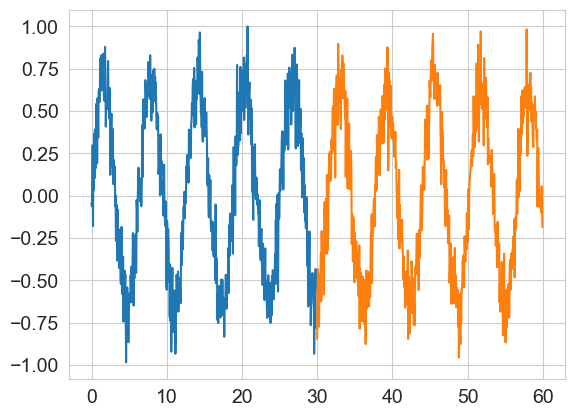

In [2]:
x_train = np.arange(0, 30, 0.05)
x_test = np.arange(30, 60, 0.05)
y_train = np.sin(x_train) + 2*np.random.randn(len(x_train)) * 0.1
y_test = np.sin(x_test) + 2*np.random.randn(len(x_test)) * 0.1
y_train_scaled = y_train / np.max(y_train)
y_test_scaled = y_test / np.max(y_train)
plt.figure()
plt.plot(x_train, y_train_scaled)
plt.plot(x_test, y_test_scaled);

In [3]:
train_dataset = TimeSeriesDataset(y_train_scaled.reshape(-1, 1), 100, 100)
train_loader = DataLoader(train_dataset, 16)

In [4]:
model = VDEncoderDecoder(1, 32, 100, 0.1, 0.001)

In [5]:
model.learn(train_loader, 100)

Epoch 100/100: 100%|██████████| 26/26 [00:00<00:00, 55.37batch/s, epoch_loss=0.0124]


In [6]:
test_dataset = TimeSeriesDataset(y_test_scaled.reshape(-1, 1), 100, 100)
test_loader = DataLoader(test_dataset, 1)

In [7]:
x, y = next(iter(test_loader))

In [8]:
preds = []
for _ in range(100):
    pred = np.squeeze(model.predict(x))
    preds.append(pred)
means = np.mean(preds, axis=0)
# Epistemic uncertainty
epistemic_unc = np.var(preds, axis=0)

In [9]:
# Aleatoric uncertanties as sum of squared residuals on train set
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
x_train, y_train = next(iter(train_dataloader))
y_hat_train = np.mean([model.predict(x_train) for _ in range(100)], axis=0)
residuals = model.predict(x_train) - y_hat_train
aleatoric_unc = np.var(residuals)

In [10]:
total_unc_std = np.sqrt(epistemic_unc + aleatoric_unc)

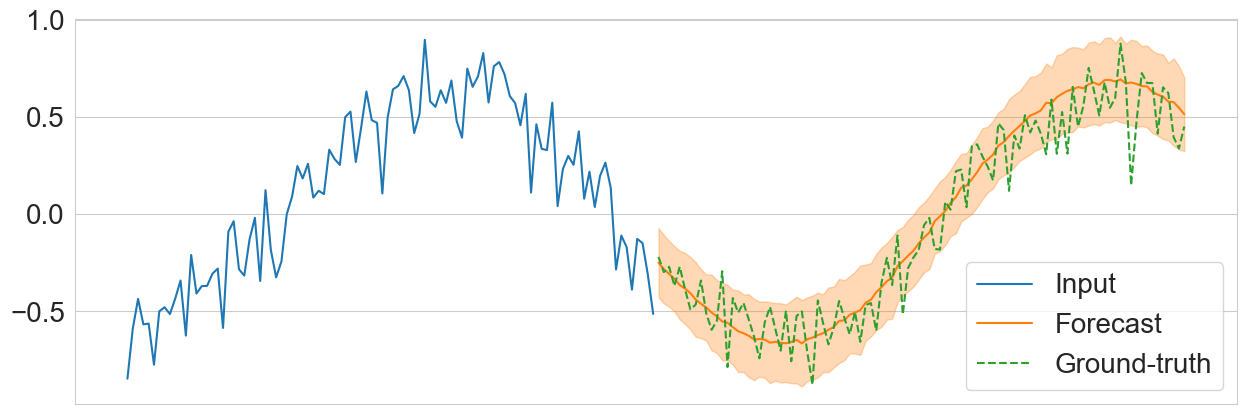

In [18]:
x = np.squeeze(x)
plt.figure(figsize=(15, 5))
plt.plot(np.arange(-len(x), 0), x, label="Input")
plt.plot(np.arange(0, len(means)), means, label='Forecast')
plt.plot(np.arange(0, len(np.squeeze(y))), np.squeeze(y), label='Ground-truth', linestyle='--')
plt.fill_between(np.arange(0, len(means)), means - 1.96*total_unc_std, means + 1.96*total_unc_std, alpha=0.3, color='tab:orange')
plt.legend();
plt.xticks([])